In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import alexnet
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Required for AlexNet
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

classes = trainset.classes


100%|██████████| 170M/170M [00:05<00:00, 29.5MB/s]


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 10)  # Modify for CIFAR-10 (10 classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 169MB/s]


In [4]:
for epoch in range(25):  # Now trains for 25 epochs
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/25], Loss: {running_loss/len(trainloader):.4f}")

Epoch [1/25], Loss: 1.8505
Epoch [2/25], Loss: 1.3671
Epoch [3/25], Loss: 1.1150
Epoch [4/25], Loss: 0.9753
Epoch [5/25], Loss: 0.9050
Epoch [6/25], Loss: 0.8344
Epoch [7/25], Loss: 0.7895
Epoch [8/25], Loss: 0.7467
Epoch [9/25], Loss: 0.7209
Epoch [10/25], Loss: 0.6808
Epoch [11/25], Loss: 0.6528
Epoch [12/25], Loss: 0.6348
Epoch [13/25], Loss: 0.6202
Epoch [14/25], Loss: 0.6083
Epoch [15/25], Loss: 0.5835
Epoch [16/25], Loss: 0.5701
Epoch [17/25], Loss: 0.5428
Epoch [18/25], Loss: 0.5454
Epoch [19/25], Loss: 0.5266
Epoch [20/25], Loss: 0.5130
Epoch [21/25], Loss: 0.5056
Epoch [22/25], Loss: 0.5031
Epoch [23/25], Loss: 0.4762
Epoch [24/25], Loss: 0.4806
Epoch [25/25], Loss: 0.4570


In [5]:
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in testloader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

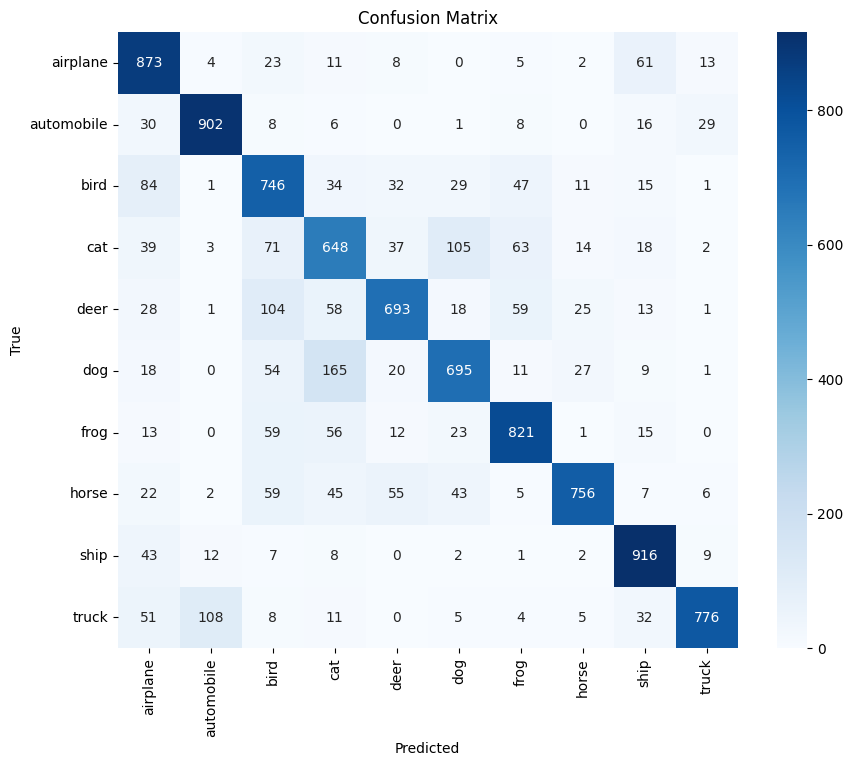

Classification Report:
              precision    recall  f1-score   support

    airplane       0.73      0.87      0.79      1000
  automobile       0.87      0.90      0.89      1000
        bird       0.65      0.75      0.70      1000
         cat       0.62      0.65      0.63      1000
        deer       0.81      0.69      0.75      1000
         dog       0.75      0.69      0.72      1000
        frog       0.80      0.82      0.81      1000
       horse       0.90      0.76      0.82      1000
        ship       0.83      0.92      0.87      1000
       truck       0.93      0.78      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



In [11]:
conf_mat = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

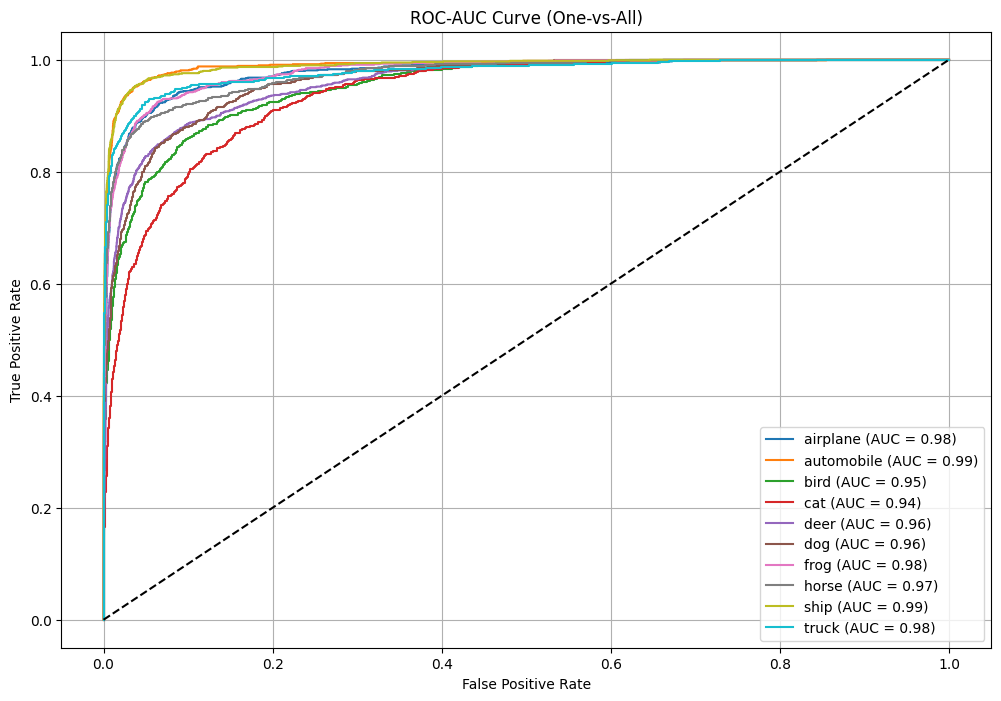

In [7]:
# Binarize labels
y_true_bin = label_binarize(all_labels, classes=np.arange(10))

# ROC AUC per class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f"{classes[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve (One-vs-All)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [8]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy  = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')  # or 'weighted'
recall    = recall_score(all_labels, all_preds, average='macro')
f1        = f1_score(all_labels, all_preds, average='macro')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Accuracy:  0.7826
Precision: 0.7896
Recall:    0.7826
F1 Score:  0.7830
